In [1]:
import numpy as np
from vowpalwabbit import pyvw
import random
import matplotlib.pyplot as plt
import pandas as pd
import itertools

In [2]:
# VW tries to minimize loss/cost, therefore we will pass cost as -reward
USER_LIKED_ARTICLE = -1.0
USER_DISLIKED_ARTICLE = 0.0

In [3]:
actions = ["politics", "sports", "music", "food", "finance", "health", "camping"]
def get_cost(context,action):
    action_max=np.argmax(context['interest'])
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == 'politics':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == actions[action_max]:
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == 'sports':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == actions[action_max]:
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE

In [4]:
# This function modifies (context, action, cost, probability) to VW friendly format
def to_vw_example_format(context, actions, cb_label = None):
    if cb_label is not None:
        chosen_action, cost, prob = cb_label
    example_string = ""
    example_string += "shared |User user={} time_of_day={} interest={} \n".format(context["user"], context["time_of_day"],context["interest"])
    for action in actions:
        if cb_label is not None and action == chosen_action:
            example_string += "0:{}:{} ".format(cost, prob)
        example_string += "|Action article={} \n".format(action)
    #Strip the last newline
    return example_string[:-1]

## Getting a decision

When we call VW we get a _pmf_, [probability mass function](https://en.wikipedia.org/wiki/Probability_mass_function), as the output. Since we are incorporating exploration into our strategy, VW will give us a list of probabilities over the set of actions. This means that the probability at a given index in the list corresponds to the likelihood of picking that specific action. In order to arrive at a decision/action, we will have to sample from this list.

So, given a list `[0.7, 0.1, 0.1, 0.1]`, we would choose the first item with a 70% chance. `sample_custom_pmf` takes such a list and gives us the index it chose and what the probability of choosing that index was.

In [5]:
def sample_custom_pmf(pmf):
    total = sum(pmf)
    scale = 1/total
    pmf = [x * scale for x in pmf]
    draw = random.random()
    sum_prob = 0.0
    for index, prob in enumerate(pmf):
        sum_prob += prob
        if(sum_prob > draw):
            return index, prob

We have all of the information we need to choose an action for a specific user and context. To use VW to achieve this, we will do the following:

1. We convert our context and actions into the text format we need
2. We pass this example to vw and get the pmf out
3. Now, we sample this pmf to get what article we will end up showing
4. Finally we return the article chosen, and the probability of choosing it (we are going to need the probability when we learn form this example)

In [6]:
def get_action(vw, context, actions):
    vw_text_example = to_vw_example_format(context,actions)    
    pmf = vw.predict(vw_text_example)
    chosen_action_index, prob = sample_custom_pmf(pmf)    
    return actions[chosen_action_index], prob



## Simulation set up

Now that we have done all of the setup work and know how to interface with VW, let's simulate the world of Tom and Anna. The scenario is they go to a website and are shown an article. Remember that the reward function allows us to define the worlds reaction to what VW recommends.


We will choose between Tom and Anna uniformly at random and also choose their time of visit uniformly at random. You can think of this as us tossing a coin to choose between Tom and Anna (Anna if heads and Tom if tails) and another coin toss for choosing time of day.


In [7]:
users = ['Tom', 'Anna']
times_of_day = ['morning', 'afternoon']
def choose_user(users):
    return random.choice(users)

def choose_time_of_day(times_of_day):
    return random.choice(times_of_day)



We will instantiate a CB learner in VW and then simulate Tom and Anna's website visits `num_iterations` number of times. In each visit, we:

1. Decide between Tom and Anna
2. Decide time of day
3. Pass context i.e. (user, time of day) to learner to get action i.e. article recommendation and probability of choosing action
4. Receive reward i.e. see if user clicked or not. Remember that cost is just negative reward.
5. Format context, action, probability, reward in VW format
6. Learn from the example
    - VW _reduces_ a CB problem to a cost sensitive multiclass classification problem.

This is the same for every one of our simulations, so we define the process in the `run_simulation` function. The cost function must be supplied as this is essentially us simulating how the world works.


In [8]:
def run_simulation(vw, num_iterations, users, times_of_day, actions, cost_function, do_learn = True):
    cost_sum = 0.
    ctr = []    

    for i in range(1, num_iterations+1):
        # 1. In each simulation choose a user
        user = choose_user(users)
        # 2. Choose time of day for a given user
        time_of_day = choose_time_of_day(times_of_day)

        # 3. Pass context to vw to get an action
        context = {'user': user, 'time_of_day': time_of_day,"interest": list(np.random.random(len(actions)))}
        action, prob = get_action(vw, context, actions)

        # 4. Get cost of the action we chose
        cost = cost_function(context, action)
        cost_sum += cost

        if do_learn:
            # 5. Inform VW of what happened so we can learn from it
            vw_format = vw.parse(to_vw_example_format(context, actions, (action, cost, prob)),pyvw.vw.lContextualBandit)            
            # 6. Learn
            vw.learn(vw_format)

        # We negate this so that on the plot instead of minimizing cost, we are maximizing reward
        ctr.append(-1*cost_sum/i)
        

    return ctr,cost_sum


We want to be able to visualize what is occurring, so we are going to plot the click through rate over each iteration of the simulation. If VW is showing actions the get rewards the ctr will be higher. Below is a little utility function to make showing the plot easier.


In [9]:
def plot_ctr(num_iterations, ctr):
    plt.plot(range(1,num_iterations+1), ctr)
    plt.xlabel('num_iterations', fontsize=14)
    plt.ylabel('ctr', fontsize=14)
    plt.ylim([0,1])

## Scenario 1

We will use the first reward function `get_cost` and assume that Tom and Anna do not change their preferences over time and see what happens to user engagement as we learn. We will also see what happens when there is no learning. We will use the "no learning" case as our baseline to compare to.

### With learning


In [10]:
# Instantiate learner in VW
# learning_rates=[10,1,1e-1,1e-2,1e-4,1e-5,1e-6]
# power_t_rates=[0,1]
# regular=[1e-9,1e-6,1e-5,1e-3,1e-2]
# num_iterations = 5000
# values={}
# iter=0
# for lr in learning_rates:
#     for pwr in power_t_rates:
#         for reg in regular:
#             vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.3"
#                          +str(' -l ')+str(lr)+str(' -r ')+str(reg)+str(' -t ')+str(pwr))
#             ctr,cost_sum = run_simulation(vw, num_iterations, users, times_of_day, actions, get_cost)    
#             values[lr,pwr,reg]=-1*cost_sum  

    
# print('Cumulative Reward='+str(-1*cost_sum))
# plot_ctr(num_iterations, ctr)

In [11]:
# max_param=max(values,key=values.get)
# print(max_param)
# print(values[max_param])

Cumulative Reward=2417.0


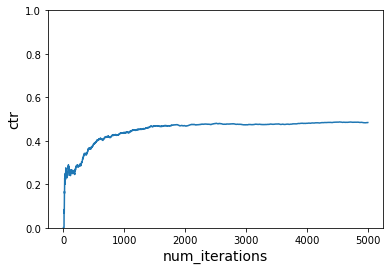

In [12]:
num_iterations = 5000
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")
ctr,cost_sum = run_simulation(vw, num_iterations, users, times_of_day, actions, get_cost)
print('Cumulative Reward='+str(-1*cost_sum))
plot_ctr(num_iterations, ctr)

#### Aside: interactions
You'll notice in the arguments we supply to VW, **we include `-q UA`**. This is telling VW to create additional features which are the features in the (U)ser namespace and (A)ction namespaces multiplied together. This allows us to learn the interaction between when certain actions are good in certain times of days and for particular users. If we didn't do that, the learning wouldn't really work. We can see that in action below.